# Home depot competition solution
In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #preprocess

from difflib import SequenceMatcher  #for LCS


# Different models
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

#Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#Visualization
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline



In [2]:
raw_data_path = "../data/raw/"
preprocessed_data_path = "../data/processed/"

# LOAD

In [3]:
train        = pd.read_csv(raw_data_path + "train.csv", encoding="ISO-8859-1") 
attributes   = pd.read_csv(raw_data_path + "attributes.csv", encoding="ISO-8859-1") 
descriptions = pd.read_csv(raw_data_path + "product_descriptions.csv", encoding="ISO-8859-1") 

display("Train:", train.head(), train.shape)
display("Attributes:", attributes.head(), attributes.shape)
display("Product descriptions:", descriptions.head(), descriptions.shape)

'Train:'

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


(74067, 5)

'Attributes:'

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


(2044803, 3)

'Product descriptions:'

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


(124428, 2)

# EDA

## MIssing values

In [6]:
print("None values count:")
print("\nTrain:", train.isna().sum(), "\nAttributes:", attributes.isna().sum(),
                                      "\nDescriptions:", descriptions.isna().sum(), sep='\n')

None values count:

Train:
id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

Attributes:
product_uid     155
name            155
value          2284
dtype: int64

Descriptions:
product_uid            0
product_description    0
dtype: int64


#### Conclusion: 
* No missing values in train.csv and product_descriptions.csv datasets, hence no treatment needed
* There are missing values in attributes.csv, additional research required

In [7]:
attributes[attributes.isnull().any(axis=1)].head(10)

,product_uid,name,value
1022,100044.0,Collection Name,NaN
1349,100058.0,Battery Size,NaN
1929,NaN,NaN,NaN
4094,NaN,NaN,NaN
4100,NaN,NaN,NaN
5909,100248.0,Fastener Thread Type,NaN
6367,100266.0,Drive Style,NaN
6823,NaN,NaN,NaN
7898,100329.0,Fastener recommendation,NaN
7901,100329.0,MFG Brand Name,NaN


#### Conclusion:
* All NaN rows cans be simply thrown away without hesitation
* It appears that attribute's name is meaningless without value. Also, this type of missing value comprises only ~2% of the whole dataset. Let's try to throw away this too

## Class balance

In [28]:
scores = train.iloc[:, 4].round(0)
scores.value_counts()

2.0    34614
3.0    34338
1.0     5115
Name: relevance, dtype: int64

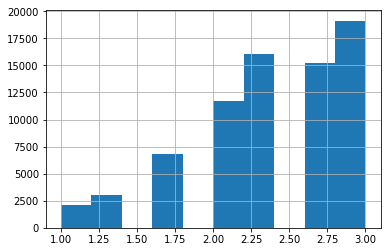

In [29]:
scores = train.iloc[:, 4]
scores.hist()

#### Conclusion: distribution is heavily shifted towards higher scores, hence accuracy may suffer

## Outliers

In [ ]:
# TODO

# MANUAL DATA INSPECTION

## Train.csv
### Observations:
* Dictionary word correction and lemmatization are needed for search_term column
* Lemmatization should be enough for product title, but it probably fine to play it safe and apply dictionary word correction too
* Standart text preprocessing is needed: remove stop words (have to do it first, to get rid from "in" **but not "in."**), dots, semicolons and any funny non-letter non-digit (might be exceptions, like measurment units and fractions) symbols etc. 
* **Symbols to remove**
    * `.`
    * `,`
    * `&`
    * `#`
    * `()`
    * `-`
    
* **Some measurment units are essentially same**, but written differently, like "in." and "inch", or "ft." and "feet", gonna deal with it somehow
    * Inches synonyms: 
        * " (they follow immediately after the number)
        * in.
        * inches
    * Feet synonyms: 
        * ' (they follow immediately after the number) 
        * ft.
        * feet
    * Pound synonyms:
        * \#  (?) unsure
        * lb
        * lbs
        * pound
    * Cubic inch:
        * cu. in.
        * cubic inch
    * Cubic feet:
        * cu. ft.
        * cubic feet
        * cubic foot
    * Gallons synonyms:
        * gal.
        * gallon
    * Yards synonyms:
        * yds. 
        * yards
    * Angstrom, synonyms:
        * å¡
        * å
* `4x6` - these should look like this: `4 x 6`
* Have to split words by capital letter, digits (if they contain them inside)
* There are a lot of `*number* in./ft. x *number* in./ft.` **but query contains only `*number* x *number*`**; have to deal with this one somehow
* `by` is synonym to `x`  
* Some words are written by all caps, should convert it to usual word with on capital letter





#  Train.csv text preprocessing summarization:


1. Remove all in list: `[',', '(', ')', '#', '&']`, replace `['-', '+']` by whitespace
1. Replace equivalent measurments by their common synonym
1. Split words by capital letter or/and digits (if they contain them inside)
1. To lowercase everything
1. Remove all double/triple/etc whitespaces
1. Replace `by` by `x`
1. For each word compute the closest word from our dictionary; of the word is too far leave it as it is
1. Lemmatize each word 
1. Create another dictionary of all words from dataset and replace words by tokens

In [47]:
train.loc[train['product_title'].str.contains("å¡")].head() # excuse me what the fuck

,id,product_uid,product_title,search_term,relevance
323,1060,100179,Paslode 3 in. x 0.120-Gauge 30å¡ Galvanized Ri...,galvanized framing nails,2.67
324,1062,100179,Paslode 3 in. x 0.120-Gauge 30å¡ Galvanized Ri...,paslode framing nails,3.00
2304,7065,101205,Grip-Rite #8 x 3 in. 16å¡ Bright Steel Duplex ...,framing nails,2.33
2620,8092,101367,DEWALT 20-Volt Max XR Lithium-Ion Cordless Bru...,dewalt xr,3.00
2621,8094,101367,DEWALT 20-Volt Max XR Lithium-Ion Cordless Bru...,lithium 20 dewalt,2.67


## Attributes.csv
### Observations:
* Bullet*somenumber* is meaningless. It's value is what matters
* If value is missing or is equal to "No", the row probaly should be ignored

### Preprocessing summarization:
1. Throw away rows with missing values or "no" in it
2. Join attributes for each product into one like this: `first_attribute_name + " " + first_attribute_value + " " second_attribute_name + second_attribute_value + ` and so on (but be sure not to include `bullet*somenumber*`)
3. Apply same tranformation as to train.csv


## Product descriptions
### Preprocessing summarization:
1. Apply same transormations as to train.csv

# TEXT PREPROCESSING

In [4]:
#remove and replace unnecessary chars

chars_to_remove = [',', '\(', '\)', '#', '\&']
chars_to_replace = ['-', '\+']

str_rem = "|".join(chars_to_remove)
str_rep = "|".join(chars_to_replace) 

def remove_chars(s):
    return re.sub(str_rem, "", s)
    
def replace_chars(s):
    return re.sub(str_rep, " ", s)
    
def train_punctuation_prep(row):
    
    title = row[0]
    search = row[1]
    
    title = remove_chars(title)
    title = replace_chars(title)
     
    search = remove_chars(search)
    search = replace_chars(search)    
    
    return pd.Series([title, search])


In [5]:
#Split words by capital letter or/and digits (if they contain them inside)

capitals_regex = re.compile('[A-Z]+[^A-Z]*|[^A-Z]+')
digits_regex = re.compile('\d+|\D+')

def split_by_capital(s):
    if re.match("[A-Z]+", s) is not None: #If s contains capital letters
        words = capitals_regex.findall(s)
        words = map(str.strip, words)
        s = " ".join(words)
    return s


def split_by_digit(s):
    if re.search("[0-9]+", s) is not None: #If s contains digits
        words = digits_regex.findall(s) # potential troublemaker!!!! might be None
        words = map(str.strip, words) 
        s = " ".join(words) 
    return s


def train_cap_dig_split(row):
    title = row[0]
    search = row[1]
    
    title = split_by_digit(split_by_capital(title))
    search = split_by_digit(split_by_capital(search))
    
    
    return pd.Series([title, search])

In [6]:
def replace_inches(s):
    s = s.replace('\'\'', ' inches')
    s = s.replace('in.', 'inches')
    return s


def replace_feet(s):
    s = s.replace('\'', ' feet')
    s = s.replace('ft.', 'feet')
    return s


def replace_pound(s):
    s = s.replace(' lb.', ' pound')
    s = s.replace(' lbs.', ' pound')
    return s


def replace_cubic(s):
    s = s.replace(' cu.', ' cubic')
    return s


def replace_gallon(s):
    s = s.replace(' gal.', ' gallon')
    return s


def replace_pound(s):
    s = s.replace(' lb', ' pound')
    s = s.replace(' lbs.', ' pound')
    return s


def replace_yards(s):
    s = s.replace(' yds.', ' yards')
    return s


def replace_angstrom(s): # just in case
    s = s.replace('å¡', ' angstrom')
    s = s.replace('å', ' angstrom')
    return s


def replace_units(s):
    s = replace_inches(s) # BEFORE FEET!
    s = replace_feet(s)
    s = replace_pound(s)
    s = replace_cubic(s)
    s = replace_gallon(s)
    s = replace_yards(s)
    s = replace_angstrom(s)
    return s

    
def train_replace_units(row):
    title = row[0]
    search = row[1]
    
    title = replace_units(title)
    search = replace_units(search)
    
    return pd.Series([title, search])

In [15]:
# lower text
def lower(s):
    return s.lower()

# remove text
def remove_mult_spaces(s):
    return re.sub(' +', ' ', s).strip()

# replace 'by' by 'x'
def by_to_x(s):
    return s.replace(' by ', ' x ')

def train_other_preprocessing(row):
    title = row[0]
    search = row[1]
    
    title = lower(title)
    title = remove_mult_spaces(title)
    title = by_to_x(title)
    
    search = lower(search)
    search = remove_mult_spaces(search)
    search = by_to_x(search)
    
    return pd.Series([title, search])

SyntaxError: invalid syntax (<ipython-input-15-8da7f2ed3b35>, line 13)

'kek'

### Train.csv

In [10]:
def prepare_train(prep_train):
    #1 Remove all in list: [',', '(', ')', '#', '&'], replace ['-', '+'] by whitespace
    prep_train[["product_title", "search_term"]] = prep_train[["product_title", "search_term"]].apply(train_punctuation_prep, axis=1)
    print("#1 Punctuation removed")
    
    #2
    prep_train[["product_title", "search_term"]] = prep_train[["product_title", "search_term"]].apply(train_replace_units, axis=1)
    print("#2 Units replaced")
    
    #3 Split by capitals and digits 
    prep_train[["product_title", "search_term"]] = prep_train[["product_title", "search_term"]].apply(train_cap_dig_split, axis=1)
    print("#3 Capitals and digits done")
    
    #4 Lower, remove whitespaces and by to x replacement
    prep_train[["product_title", "search_term"]] = prep_train[["product_title", "search_term"]].apply(train_other_preprocessing, axis=1)
    print("#4 Lower, remove whitespaces and by to x replacement")
        
    return(prep_train)


prep_train = train.copy()
prep_train = parallelize(prep_train, prepare_train)
display(prep_train[["product_title", "search_term"]].head(10))

#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done


,product_title,search_term
0,Simpson Strong Tie 12 Gauge Angle,angle bracket
1,Simpson Strong Tie 12 Gauge Angle,l bracket
2,BEHR Premium Textured Deck Over 1 gallon SC 14...,deck over
3,Delta Vero 1 Handle Shower Only Faucet Trim Ki...,rain shower head
4,Delta Vero 1 Handle Shower Only Faucet Trim Ki...,shower only faucet
5,Whirlpool 1 . 9 cubic feet Over the Range Conv...,convection otr
6,Whirlpool 1 . 9 cubic feet Over the Range Conv...,microwave over stove
7,Whirlpool 1 . 9 cubic feet Over the Range Conv...,microwaves
8,Lithonia Lighting Quantum 2 Light Black LED Em...,emergency light
9,House of Fara 3 / 4 inches x 3 inches x 8 feet...,mdf 3 / 4


In [11]:
import gc
gc.collect()

46

In [13]:
prep_train.to_csv(preprocessed_data_path + "train.csv")

# HELPERS

In [15]:
# LONGEST COMMON SUBSTRING
def matchsubstring(m,n): 
    seqMatch = SequenceMatcher(None,m,n) 
    match = seqMatch.find_longest_match(0, len(m), 0, len(n)) 
    return m[match.a: match.a + match.size]

In [8]:
from multiprocessing import  Pool
from functools import partial


def parallelize(data, func, num_of_processes=8):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=8):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

# FEATURE ENGINEERING

In [16]:
dataset = []
for i in range(train.shape[0]):
    desc = train.iloc[i, 2]
    query = train.iloc[i, 3]
    score = train.iloc[i,4]
    lcs = matchsubstring(desc.lower(), query.lower()) # longest common substring
    overlap = len(lcs)
    dataset.append([overlap, score])
dataset = np.array(dataset)
    
print(dataset.shape)

(74067, 2)


# DATASET PREPARATION

In [17]:
X, y = [dataset[:, 0], dataset[:, 1]]
X = X.reshape(X.shape[0], 1)
y = y
print(X.shape, y.shape, dataset.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(74067, 1) (74067,) (74067, 2)


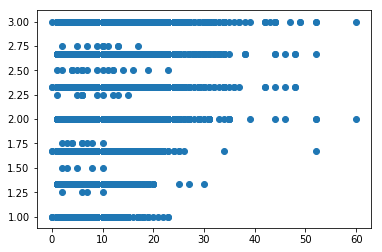

In [21]:
plt.scatter(X, y, alpha=1)
plt.show()

# BASELINE MODEL

In [22]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)


In [23]:
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [24]:

#model = LinearRegression()
#model.fit(X_train, y_train)
#y_preds = model.predict(X_test)

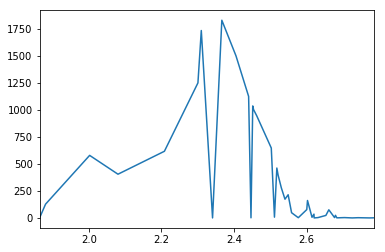

In [25]:
y_preds[y_preds>3] = 3
values = pd.Series(y_preds).value_counts() 
values.sort_index().plot(kind='line')

# EVALUATION

In [26]:
#RMSE

np.sqrt(mean_squared_error(y_preds, y_test))

0.5130611995212965

In [27]:
# naive submission test
np.sqrt(mean_squared_error(np.zeros(14814)+3, y_test))

0.815684128037821

### Baseline, RMSE - 0.513, while: 
* best score on lb: 0.431
* all 1 submission score: 1.481
* all 2 submission score: 0.655
* all 3 submission score: 0.815

# INFERENCE DATA LOAD

In [28]:
submission = pd.read_csv(input_path + "test.csv", engine="python")
dataset = []
for i in range(submission.shape[0]):
    desc =  submission.iloc[i, 2]
    query = submission.iloc[i, 3]
    lcs = matchsubstring(desc.lower(), query.lower()) # longest common substring
    overlap = len(lcs)
    dataset.append([overlap])
dataset = np.array(dataset)
dataset.shape

(166693, 1)

# INFERENCE

In [29]:
res = model.predict(dataset)
pd.Series(res).value_counts() 

2.309699    20207
2.366322    19982
2.405317    16358
2.300432    14843
2.440167    12511
2.451519    10876
2.453807    10558
2.462379     9938
2.208040     7820
2.502626     7213
2.001926     7108
2.517936     5316
2.521558     4793
2.080039     4397
2.530338     3152
2.549126     2385
2.540354     2096
1.880398     1874
2.602454     1293
2.600461      914
2.661237      745
2.558575      555
2.620296      368
2.653108      286
2.679566      262
2.614865      163
2.511387      156
2.677061       92
2.631297       81
2.446669       60
2.577074       46
2.242688       42
1.863927       30
2.506648       24
2.704338       21
2.741713       21
2.751972       19
2.683192       13
2.620749       12
2.786805       12
2.773557        9
2.687377        9
2.791877        7
2.452969        4
2.340735        4
2.378362        4
2.712363        4
2.725701        4
2.337368        2
2.542676        2
2.623326        2
dtype: int64

# OUTPUT

In [30]:
res[res>3] = 3
res = pd.DataFrame(res, columns=['relevance'])
res['id'] = submission['id']
res = res[['id', 'relevance']]
res.head()

,id,relevance
0,1,2.001926
1,4,1.880398
2,5,2.440167
3,6,2.517936
4,7,2.517936


In [31]:
res.loc[res['relevance']>=3]

,id,relevance


In [32]:
res.to_csv('output.csv', index=False)

In [33]:
tmp = pd.read_csv("output.csv")
tmp.loc[tmp['relevance']>3]

,id,relevance


In [34]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 2 columns):
id           166693 non-null int64
relevance    166693 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.5 MB


In [35]:
!head output.csv 

id,relevance
1,2.001926138644444
4,1.880398441318938
5,2.4401667969070053
6,2.517935886475066
7,2.517935886475066
8,2.001926138644444
10,2.6024539827454927
11,2.366322356378352
12,2.366322356378352
